<a href="https://colab.research.google.com/github/gabrielgraciano/analise_de_filmes/blob/main/movie_scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from google.colab import userdata

try:
  token = userdata.get('TMDB_TOKEN')
except userdata.SecretNotFoundError:
  print('Errp')
  token = None
if token:
    # 2. Define o endpoint de validação
    url = "https://api.themoviedb.org/3/authentication"

    # 3. Monta o cabeçalho de autorização
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {token}"
    }

    # 4. Faz a requisição GET
    response = requests.get(url, headers=headers)

    # 5. Valida a resposta
    if response.status_code == 200:
        print("✅ Sucesso! API validada perfeitamente.")
        print("Resposta do servidor:", response.json())
    else:
        print(f"❌ Falha na autenticação. Código de erro: {response.status_code}")
        print("Detalhes:", response.text)

✅ Sucesso! API validada perfeitamente.
Resposta do servidor: {'success': True}


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# 1. Pegamos a data de ontem para garantir que o arquivo já foi gerado pelo TMDB
ontem = datetime.now() - timedelta(days=1)
data_formatada = ontem.strftime('%m_%d_%Y') # Formato MM_DD_YYYY

# 2. Montamos a URL oficial do TMDB Exports
url_export = f"http://files.tmdb.org/p/exports/movie_ids_{data_formatada}.json.gz"
print(f"Iniciando o download de: {url_export} ... (Isso pode levar de 1 a 2 minutos)")

# 3. O Pandas lê direto da URL. O parâmetro lines=True é essencial porque o arquivo tem um JSON por linha
try:
    df_filmes = pd.read_json(url_export, lines=True)
    print("✅ Download concluído e carregado no Pandas!")

    # 4. Limpeza inicial: tirando os filmes adultos
    tamanho_original = len(df_filmes)
    df_filmes = df_filmes[df_filmes['adult'] == False]

    # Vamos ver como ficou
    print(f"\nTotal de filmes antes do filtro: {tamanho_original}")
    print(f"Total de filmes 'não-adultos' válidos para análise: {len(df_filmes)}")
    print("\nVisualizando as primeiras linhas:")
    display(df_filmes.head())

except Exception as e:
    print(f"❌ Erro ao baixar ou ler o arquivo: {e}")

Iniciando o download de: http://files.tmdb.org/p/exports/movie_ids_02_13_2026.json.gz ... (Isso pode levar de 1 a 2 minutos)
✅ Download concluído e carregado no Pandas!

Total de filmes antes do filtro: 1160646
Total de filmes 'não-adultos' válidos para análise: 1160646

Visualizando as primeiras linhas:


,adult,id,original_title,popularity,video
0,False,3924,Blondie,3.4933,False
1,False,8773,L'Amour à vingt ans,0.6461,False
2,False,25449,New World Disorder 9: Never Enough,0.0750,False
3,False,31975,Sesame Street: Elmo Loves You!,0.0516,True
4,False,2,Ariel,5.0295,False


=== Resumo Estatístico da Popularidade ===
count    1.160646e+06
mean     3.696804e-01
std      1.183154e+00
min      0.000000e+00
25%      4.290000e-02
50%      1.142000e-01
75%      3.150000e-01
90%      8.385000e-01
95%      1.639175e+00
99%      3.861355e+00
max      3.650310e+02
Name: popularity, dtype: float64




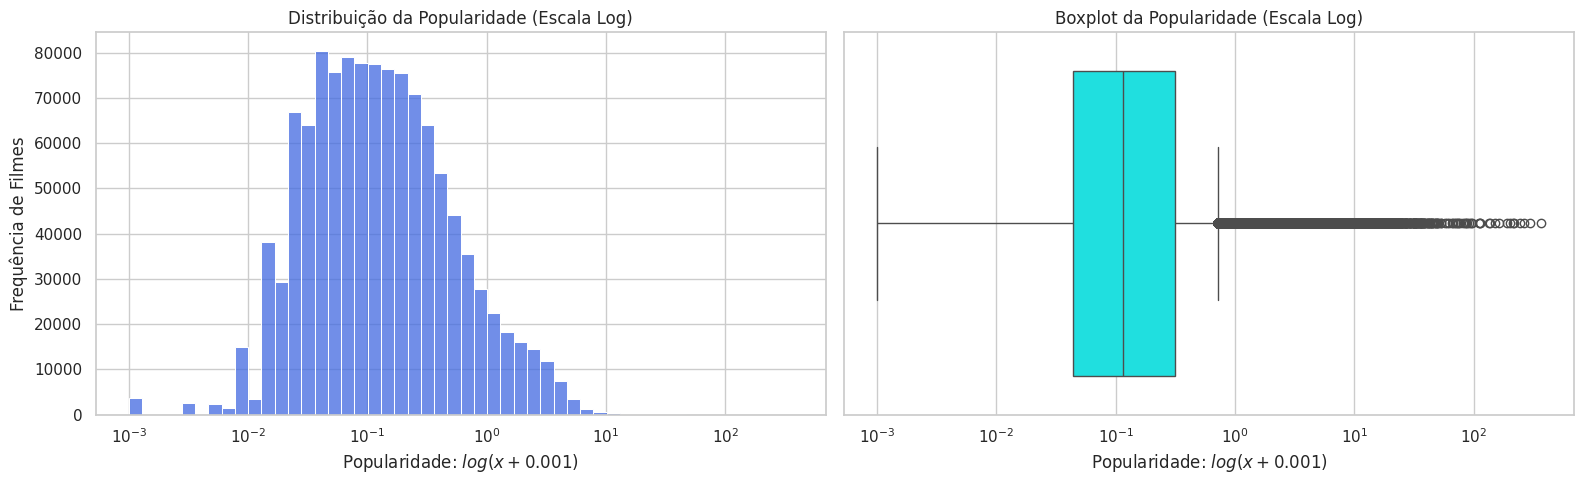

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Calculando os quartis e decis (estatísticas descritivas)
# Adicionei os percentis 90, 95 e 99 porque é lá que a "mágica" acontece nessa base
percentis = [0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
estatisticas = df_filmes['popularity'].describe(percentiles=percentis)

print("=== Resumo Estatístico da Popularidade ===")
print(estatisticas)
print("\n")

# 2. Configurando a área de plotagem
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Histograma com Escala Logarítmica no eixo X
# Um macete de Data Science: somamos uma constante pequena para evitar log(0)
sns.histplot(df_filmes['popularity'] + 0.001, bins=50, log_scale=(True, False), ax=ax[0], color='royalblue')
ax[0].set_title('Distribuição da Popularidade (Escala Log)')
ax[0].set_xlabel('Popularidade: $log(x + 0.001)$')
ax[0].set_ylabel('Frequência de Filmes')

# Gráfico 2: Boxplot (também em Log) para visualizar os outliers
sns.boxplot(x=df_filmes['popularity'] + 0.001, ax=ax[1], color='cyan')
ax[1].set_xscale('log')
ax[1].set_title('Boxplot da Popularidade (Escala Log)')
ax[1].set_xlabel('Popularidade: $log(x + 0.001)$')

plt.tight_layout()
plt.show()

Total de filmes após o corte (> 0.838): 116122 filmes


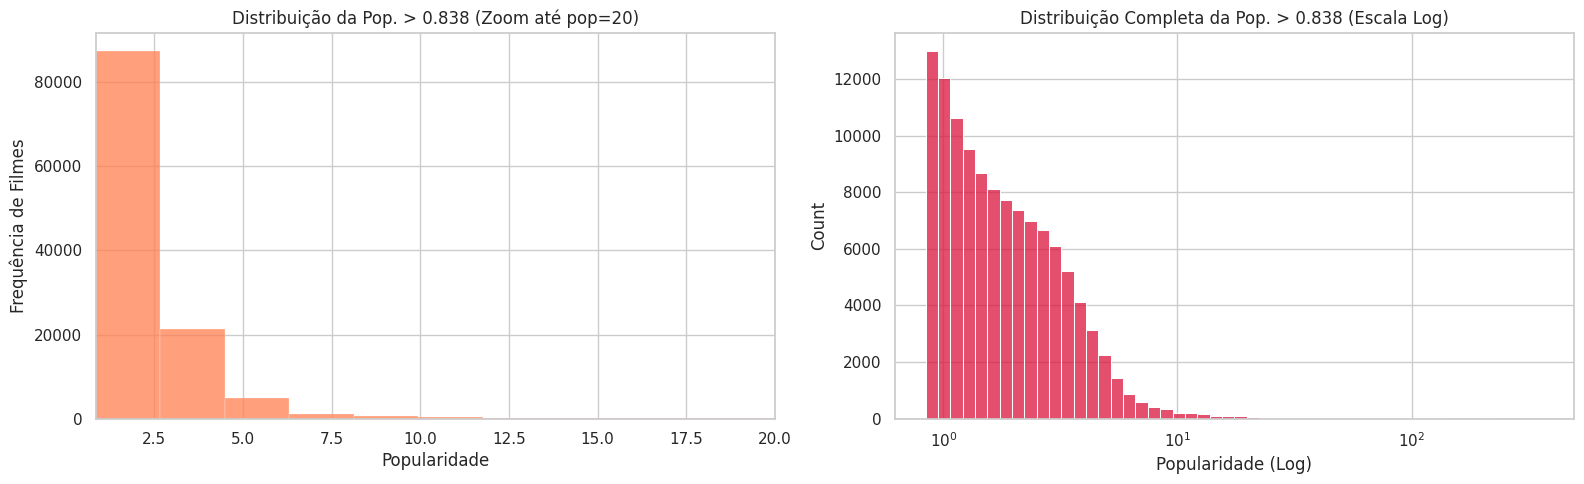

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicando o filtro do percentil 90
filtro_pop = 0.838
df_top10 = df_filmes[df_filmes['popularity'] > filtro_pop]

print(f"Total de filmes após o corte (> {filtro_pop}): {len(df_top10)} filmes")

# 2. Configurando a visualização
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Histograma Linear (Focado no "grosso" dos dados filtrados)
# Usando um limite no eixo X (ex: até 20) para conseguirmos enxergar as barras,
# já que os outliers de 300 achatariam tudo.
sns.histplot(df_top10['popularity'], bins=200, ax=ax[0], color='coral')
ax[0].set_xlim(0.838, 20) # Focando onde está a maior densidade
ax[0].set_title('Distribuição da Pop. > 0.838 (Zoom até pop=20)')
ax[0].set_xlabel('Popularidade')
ax[0].set_ylabel('Frequência de Filmes')

# Gráfico 2: Histograma com Escala Logarítmica no eixo X
# Aqui conseguimos ver a distribuição completa do top 10% sem cortar os outliers de 300
sns.histplot(df_top10['popularity'], bins=50, log_scale=(True, False), ax=ax[1], color='crimson')
ax[1].set_title('Distribuição Completa da Pop. > 0.838 (Escala Log)')
ax[1].set_xlabel('Popularidade (Log)')

plt.tight_layout()
plt.show()

In [ ]:
import requests
import json
from google.colab import userdata

# Recuperando o token
token = userdata.get('TMDB_TOKEN')
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {token}"
}

# ID 4995 (Boogie Nights) para o nosso teste de schema
movie_id = 4995
url_details = f"https://api.themoviedb.org/3/movie/{movie_id}"

# Fazendo a requisição
response = requests.get(url_details, headers=headers)
filme_teste = response.json()

# 1. Quais são todos os campos disponíveis para esse filme?
print("=== TODAS AS CHAVES (CAMPOS) DISPONÍVEIS ===")
for chave in filme_teste.keys():
    print(f"- {chave}")

# 2. Inspecionando como vêm os campos que precisamos para o mapa
print("\n=== ESTRUTURA DOS GÊNEROS ===")
print(json.dumps(filme_teste.get('genres'), indent=2))

print("\n=== ESTRUTURA DOS PAÍSES DE PRODUÇÃO ===")
print(json.dumps(filme_teste.get('production_countries'), indent=2))

# 3. Inspecionando campos úteis para futuros dashboards
print("\n=== CAMPOS FINANCEIROS E DE TEMPO ===")
print(f"Orçamento (Budget): ${filme_teste.get('budget'):,}")
print(f"Receita (Revenue): ${filme_teste.get('revenue'):,}")
print(f"Duração (Runtime): {filme_teste.get('runtime')} minutos")

=== TODAS AS CHAVES (CAMPOS) DISPONÍVEIS ===
- adult
- backdrop_path
- belongs_to_collection
- budget
- genres
- homepage
- id
- imdb_id
- origin_country
- original_language
- original_title
- overview
- popularity
- poster_path
- production_companies
- production_countries
- release_date
- revenue
- runtime
- spoken_languages
- status
- tagline
- title
- video
- vote_average
- vote_count

=== ESTRUTURA DOS GÊNEROS ===
[
  {
    "id": 18,
    "name": "Drama"
  }
]

=== ESTRUTURA DOS PAÍSES DE PRODUÇÃO ===
[
  {
    "iso_3166_1": "US",
    "name": "United States of America"
  }
]

=== CAMPOS FINANCEIROS E DE TEMPO ===
Orçamento (Budget): $15,000,000
Receita (Revenue): $43,101,594
Duração (Runtime): 156 minutos


In [ ]:
import requests
import pandas as pd
from google.colab import userdata

# 1. Recuperando o token
token = userdata.get('TMDB_TOKEN')
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {token}"
}

ids_para_comparar = [4995, 13, 14]
dados_filmes = []

print("Buscando dados completos na API...\n")

for movie_id in ids_para_comparar:
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        filme = response.json()

        # 2. Tratando todos os campos complexos (listas de dicionários)
        generos = [g.get('name') for g in filme.get('genres', [])]
        paises = [p.get('iso_3166_1') for p in filme.get('production_countries', [])]
        empresas = [e.get('name') for e in filme.get('production_companies', [])]
        idiomas = [i.get('iso_639_1') for i in filme.get('spoken_languages', [])]

        # Tratando dicionários opcionais (pode vir nulo se não pertencer a uma coleção)
        colecao = filme.get('belongs_to_collection')
        nome_colecao = colecao.get('name') if colecao else None

        # 3. Montando a linha plana (flat)
        dados_filmes.append({
            'id': filme.get('id'),
            'imdb_id': filme.get('imdb_id'),
            'title': filme.get('title'),
            'original_title': filme.get('original_title'),
            'original_language': filme.get('original_language'),
            'release_date': filme.get('release_date'),
            'runtime': filme.get('runtime'),
            'status': filme.get('status'),
            'tagline': filme.get('tagline'),
            'overview': filme.get('overview'),
            'adult': filme.get('adult'),
            'video': filme.get('video'),
            'budget': filme.get('budget'),
            'revenue': filme.get('revenue'),
            'popularity': filme.get('popularity'),
            'vote_average': filme.get('vote_average'),
            'vote_count': filme.get('vote_count'),
            'genres': ", ".join(generos) if generos else None,
            'production_countries': ", ".join(paises) if paises else None,
            'production_companies': ", ".join(empresas) if empresas else None,
            'spoken_languages': ", ".join(idiomas) if idiomas else None,
            'origin_country': ", ".join(filme.get('origin_country', [])),
            'belongs_to_collection': nome_colecao,
            'homepage': filme.get('homepage'),
            'poster_path': filme.get('poster_path'),
            'backdrop_path': filme.get('backdrop_path')
        })
    else:
        print(f"Erro ao buscar o ID {movie_id}. Status: {response.status_code}")

# 4. Criando e exibindo o DataFrame com todas as colunas
df_completo = pd.DataFrame(dados_filmes)

# Configurando o Pandas para mostrar todas as colunas no Colab sem ocultar no meio
pd.set_option('display.max_columns', None)
display(df_completo)

Buscando dados completos na API...



,id,imdb_id,title,original_title,original_language,release_date,runtime,status,tagline,overview,adult,video,budget,revenue,popularity,vote_average,vote_count,genres,production_countries,production_companies,spoken_languages,origin_country,belongs_to_collection,homepage,poster_path,backdrop_path
0,4995,tt0118749,Boogie Nights,Boogie Nights,en,1997-10-10,156,Released,"The life of a dreamer, the days of a business ...","Set in 1977, back when sex was safe, pleasure ...",False,False,15000000,43101594,8.0834,7.600,3460,Drama,US,"New Line Cinema, Lawrence Gordon Productions, ...",en,US,None,,/wnE24UPCPQsQnbBOu4zVE2qaDNm.jpg,/ArpTzQZHWh4UVsgUvV6S7WjTq1n.jpg
1,13,tt0109830,Forrest Gump,Forrest Gump,en,1994-06-23,142,Released,The world will never be the same once you've s...,A man with a low IQ has accomplished great thi...,False,False,55000000,677387716,23.7683,8.462,29232,"Comedy, Drama, Romance",US,"Paramount Pictures, The Steve Tisch Company, W...",en,US,None,https://www.paramountmovies.com/movies/forrest...,/saHP97rTPS5eLmrLQEcANmKrsFl.jpg,/67HggiWaP9ZLv5sPYmyRV37yAJM.jpg
2,14,tt0169547,American Beauty,American Beauty,en,1999-09-15,122,Released,... look closer,"Lester Burnham, a depressed suburban father in...",False,False,15000000,356296601,8.5031,8.003,12794,Drama,US,"DreamWorks Pictures, Jinks/Cohen Company",en,US,None,,/wby9315QzVKdW9BonAefg8jGTTb.jpg,/2ndw55F40IkALzWyjCCza3M6nqM.jpg
